In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# 1. Load the Dataset
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


In [4]:
# Separate features and target
X = train.drop(['SalePrice', 'Id'], axis=1)
y = train['SalePrice']
test_ids = test['Id']
X_test = test.drop('Id', axis=1)

In [5]:
# 2. Exploratory Data Analysis (EDA)
print("\n=== EDA ===")
# Check missing values
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("\nMissing Values:\n", missing)


=== EDA ===

Missing Values:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


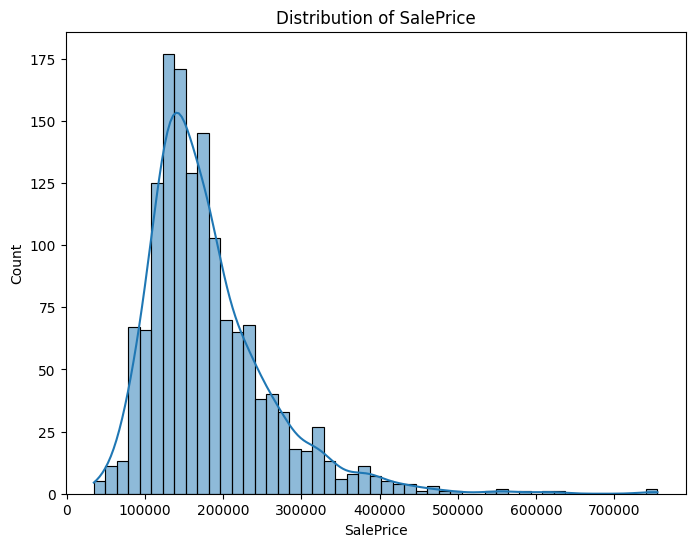

In [6]:
# Visualize target variable distribution
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.show()

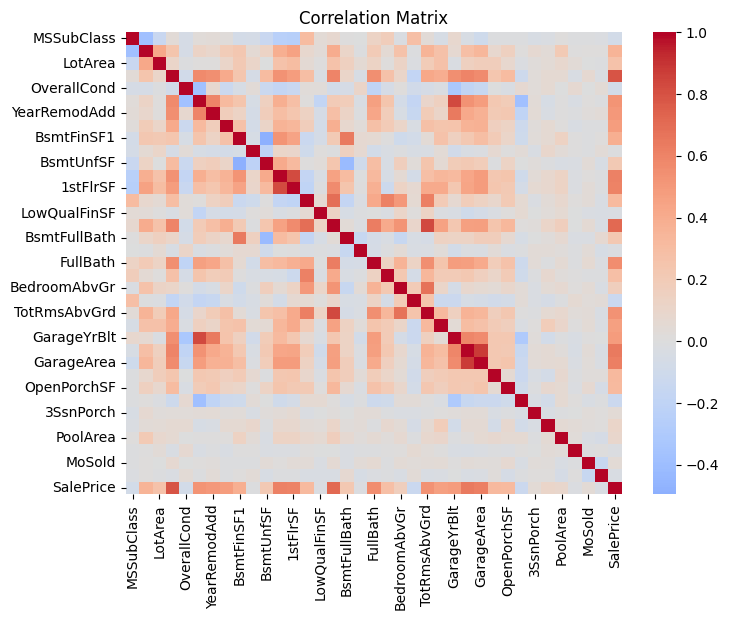

In [7]:
# Correlation matrix for numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train[numerical_cols.tolist() + ['SalePrice']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [8]:
# 3. Data Preprocessing
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)
X_test_preprocessed = preprocessor.transform(X_test)
print("\nPreprocessed train shape:", X_preprocessed.shape)
print("Preprocessed test shape:", X_test_preprocessed.shape)


Preprocessed train shape: (1460, 303)
Preprocessed test shape: (1459, 303)


In [9]:
# 4. Train Multiple Models with Cross-Validation
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0)
}

# Evaluate models using 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    rmse_scores = -scores
    results.append({
        'Model': name,
        'Mean RMSE': rmse_scores.mean(),
        'Std RMSE': rmse_scores.std(),
        'R² Score': cross_val_score(pipeline, X, y, cv=kf, scoring='r2').mean()
    })
    print(f"{name} - Mean RMSE: {rmse_scores.mean():.2f}, Std RMSE: {rmse_scores.std():.2f}")

Linear Regression - Mean RMSE: 262793188115076.34, Std RMSE: 294782894847888.88
Random Forest - Mean RMSE: 30290.74, Std RMSE: 7125.31
Gradient Boosting - Mean RMSE: 28654.82, Std RMSE: 9447.70
XGBoost - Mean RMSE: 30653.16, Std RMSE: 7197.94
LightGBM - Mean RMSE: 29277.13, Std RMSE: 6437.77
CatBoost - Mean RMSE: 27076.78, Std RMSE: 6630.40


In [10]:
# 5. Compare Results
results_df = pd.DataFrame(results).sort_values(by='R² Score', ascending=False)
print("\n=== Model Comparison ===")
print(results_df)


=== Model Comparison ===
               Model     Mean RMSE      Std RMSE      R² Score
5           CatBoost  2.707678e+04  6.630404e+03  8.722232e-01
4           LightGBM  2.927713e+04  6.437770e+03  8.536172e-01
2  Gradient Boosting  2.865482e+04  9.447700e+03  8.479734e-01
1      Random Forest  3.029074e+04  7.125307e+03  8.402557e-01
3            XGBoost  3.065316e+04  7.197939e+03  8.356488e-01
0  Linear Regression  2.627932e+14  2.947829e+14 -2.358745e+19


In [11]:
# 6. Hyperparameter Tuning for Top Models
# Select top 2 models based on R² Score
top_models = results_df.head(2)['Model'].values
print(f"\nTuning hyperparameters for: {top_models}")

param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'LightGBM': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'CatBoost': {
        'model__iterations': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__depth': [3, 5]
    }
}

best_models = {}
for model_name in top_models:
    if model_name in models:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[model_name])])
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid_search.fit(X, y)
        best_models[model_name] = grid_search.best_estimator_
        print(f"\n{model_name} Best Params: {grid_search.best_params_}")
        print(f"{model_name} Best RMSE: {-grid_search.best_score_:.2f}")


Tuning hyperparameters for: ['CatBoost' 'LightGBM']

CatBoost Best Params: {'model__depth': 5, 'model__iterations': 200, 'model__learning_rate': 0.1}
CatBoost Best RMSE: 27277.35

LightGBM Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
LightGBM Best RMSE: 29192.61


In [12]:
# 7. Train Best Model and Generate Predictions
# Select the model with the highest R² score
best_model_name = results_df.iloc[0]['Model']
if best_model_name in best_models:
    best_model = best_models[best_model_name]
else:
    best_model = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[best_model_name])])
    best_model.fit(X, y)

In [13]:
# Generate predictions for test set
predictions = best_model.predict(X_test)

In [14]:
# Create submission file
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
print(f"\nSubmission file created: submission.csv using {best_model_name}")


Submission file created: submission.csv using CatBoost


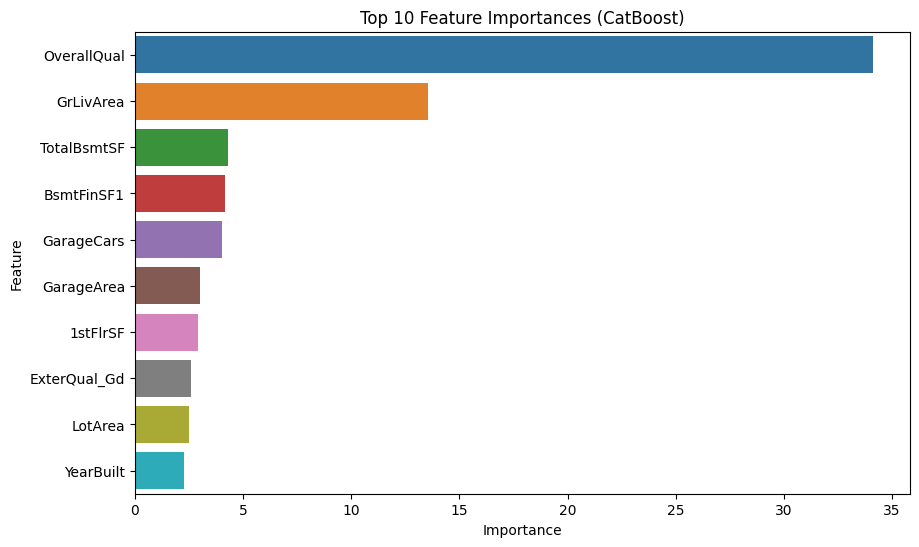

In [15]:
# Visualize feature importance
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    feature_names = numerical_cols.tolist() + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))
    importances = best_model.named_steps['model'].feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Top 10 Feature Importances ({best_model_name})')
    plt.show()